## **1. Thực hiện thuật toán decision tree**

### **1.1 Chuẩn bị tập dữ liệu**

#### Thêm các thư viện cần thiết

In [5]:
# Xử lý và tính toán số học, ma trận
import numpy as np

# Xử lý và phân tích dữ liệu dạng bảng
import pandas as pd

# Vẽ đồ thị, biểu đồ cơ bản
import matplotlib.pyplot as plt

# Chia dữ liệu thành tập huấn luyện và kiểm thử
from sklearn.model_selection import train_test_split

# Triển khai thuật toán cây quyết định (Decision Tree)
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Chuẩn hóa dữ liệu (z-score standardization)
from sklearn.preprocessing import StandardScaler

# Đánh giá mô hình với các chỉ số phổ biến
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Vẽ biểu đồ nâng cao và trực quan hóa
import seaborn as sns

# Đếm số lượng phần tử trong danh sách hoặc chuỗi
from collections import Counter

# Trực quan hóa cây quyết định dưới dạng đồ thị
import graphviz

# Hiển thị trực tiếp các đối tượng trong Jupyter Notebook
from IPython.display import display, Image, SVG

# Tương tác với hệ thống tệp
import os

import warnings

import re

In [6]:
pd.set_option('display.max_columns', None)
column_names = ['Area','Perimeter','Major_Axis_Length','Minor_Axis_Length','Eccentricity','Convex_Area','Extent','Class']
df = pd.read_csv('Rice_Cammeo_Osmancik.csv', names=column_names)
df

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo
...,...,...,...,...,...,...,...,...
3805,11441,415.858002,170.486771,85.756592,0.864280,11628,0.681012,Osmancik
3806,11625,421.390015,167.714798,89.462570,0.845850,11904,0.694279,Osmancik
3807,12437,442.498993,183.572922,86.801979,0.881144,12645,0.626739,Osmancik
3808,9882,392.296997,161.193985,78.210480,0.874406,10097,0.659064,Osmancik


#### **1.1.1 Tiền xử lý dữ liệu**

#### Kiểm tra thông tin các đặc trưng có trong tập dữ liệu

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.3+ KB
None


Do không có dòng nào trống nên không cần fill

#### **1.1.2 Chia dữ liệu theo tỷ lệ**

#### Chuẩn bị các đặc trưng và mục tiêu

In [13]:
# Các tỷ lệ chia tập huấn luyện/kiểm trap
proportions = [0.4, 0.6, 0.8, 0.9]

# Features
features = df.drop(columns=['Class'])

feature_names = features.columns.to_list()

# Label
label = df['Class']

# Random state
random_state = 42

#### Viết hàm `stratified_split` để phân chia chia dữ liệu theo tỷ

In [15]:
def stratified_split(X, y, train_size, random_state=42):
    """
    Chia dữ liệu theo kiểu phân tầng.
    
    Parameters:
    - X: Dữ liệu đầu vào (features)
    - y: Nhãn (labels)
    - test_size: Tỷ lệ dữ liệu test
    - random_state: Giá trị seed để tái tạo
    
    Returns:
    - feature_train, feature_test, label_train, label_test: Dữ liệu sau khi chia
    """
    test_size = 1 - train_size
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

#### Viết hàm `visualize_train_test_distribution` để trực quan hóa các tập dữ liệu sau khi chia

In [17]:
def visualize_train_test_distribution(y, y_train, y_test, train_size):
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
    
    classes = ['Cammeo', 'Osmancik']
    
    # Phân phối gốc
    original_counts = [Counter(y)[ele] for ele in classes]
    axes[0].bar(classes, original_counts)
    axes[0].set_title('Original Dataset')
    axes[0].set_ylabel('Count')
    for i, count in enumerate(original_counts):
        axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    # Phân phối tập train
    train_counts = [Counter(y_train)[ele] for ele in classes]
    axes[1].bar(classes, train_counts)
    axes[1].set_title(f'Training Set ({int(round(train_size, 2)* 100)}%)')
    for i, count in enumerate(train_counts):
        axes[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    # Phân phối tập test
    test_counts = [Counter(y_test)[ele] for ele in classes]
    axes[2].bar(classes, test_counts)
    axes[2].set_title(f'Test Set ({int(round((1 - train_size), 2) * 100)}%)')
    for i, count in enumerate(test_counts):
        axes[2].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    plt.tight_layout()
    os.makedirs('./output/split', exist_ok=True)
    plt.savefig(f'./output/split/train_test_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f'./output/split/train_test_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}.svg', format='svg', bbox_inches='tight')
    plt.show()

#### Thực hiện việc chia dữ liệu và trực quan hóa theo các tỷ lệ nhất định

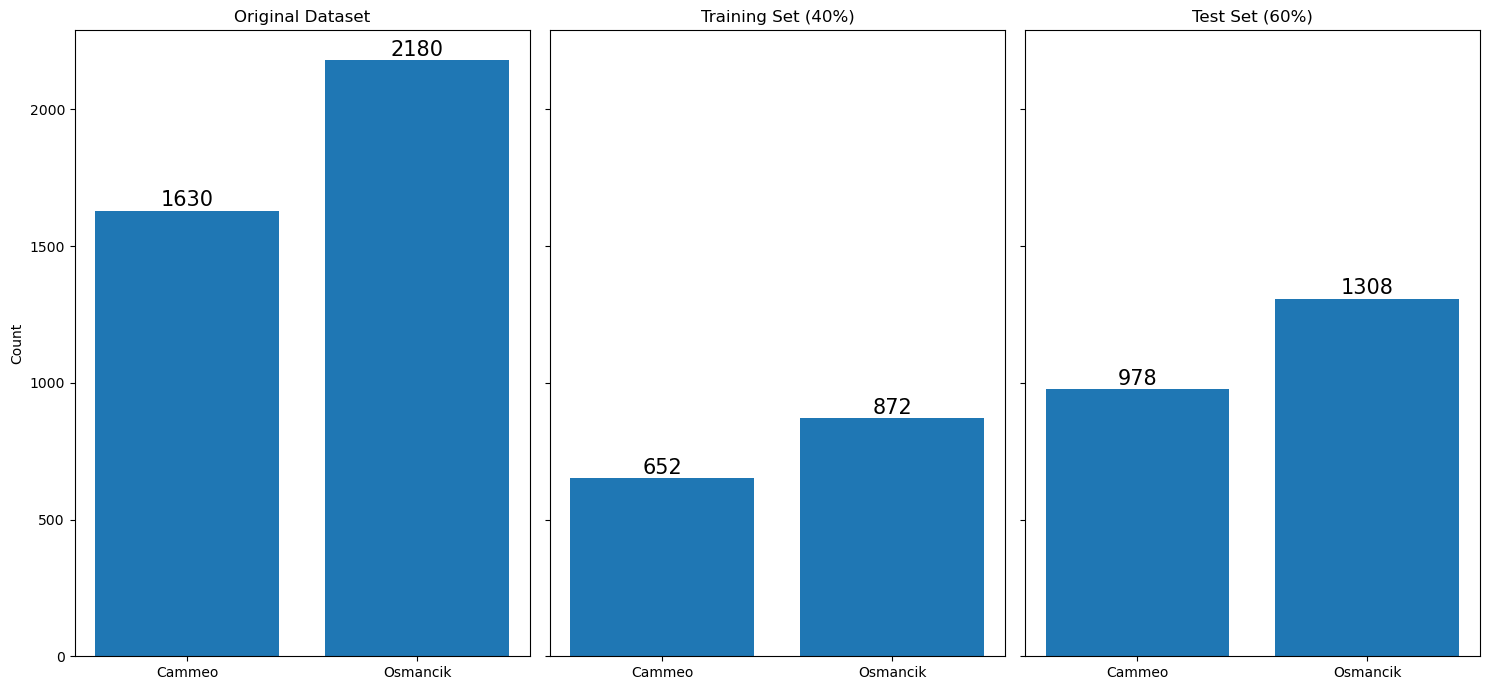

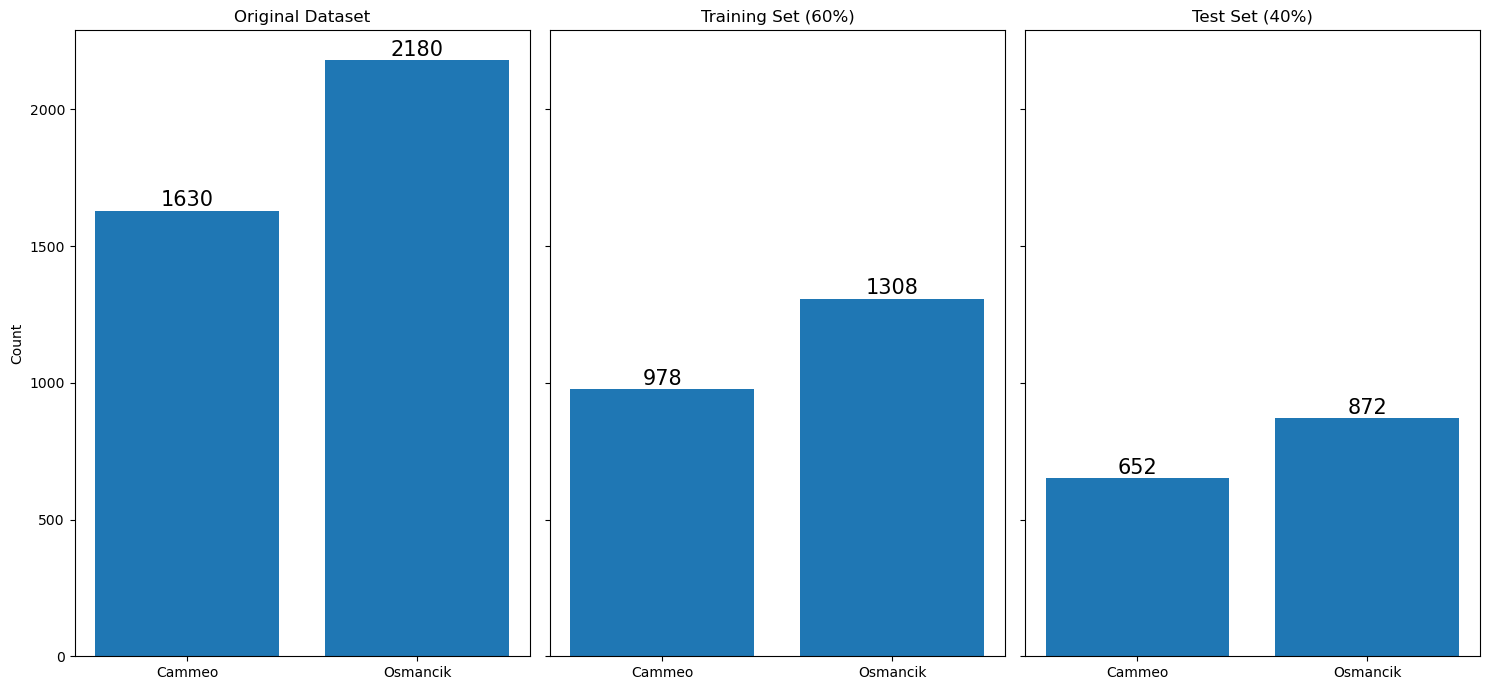

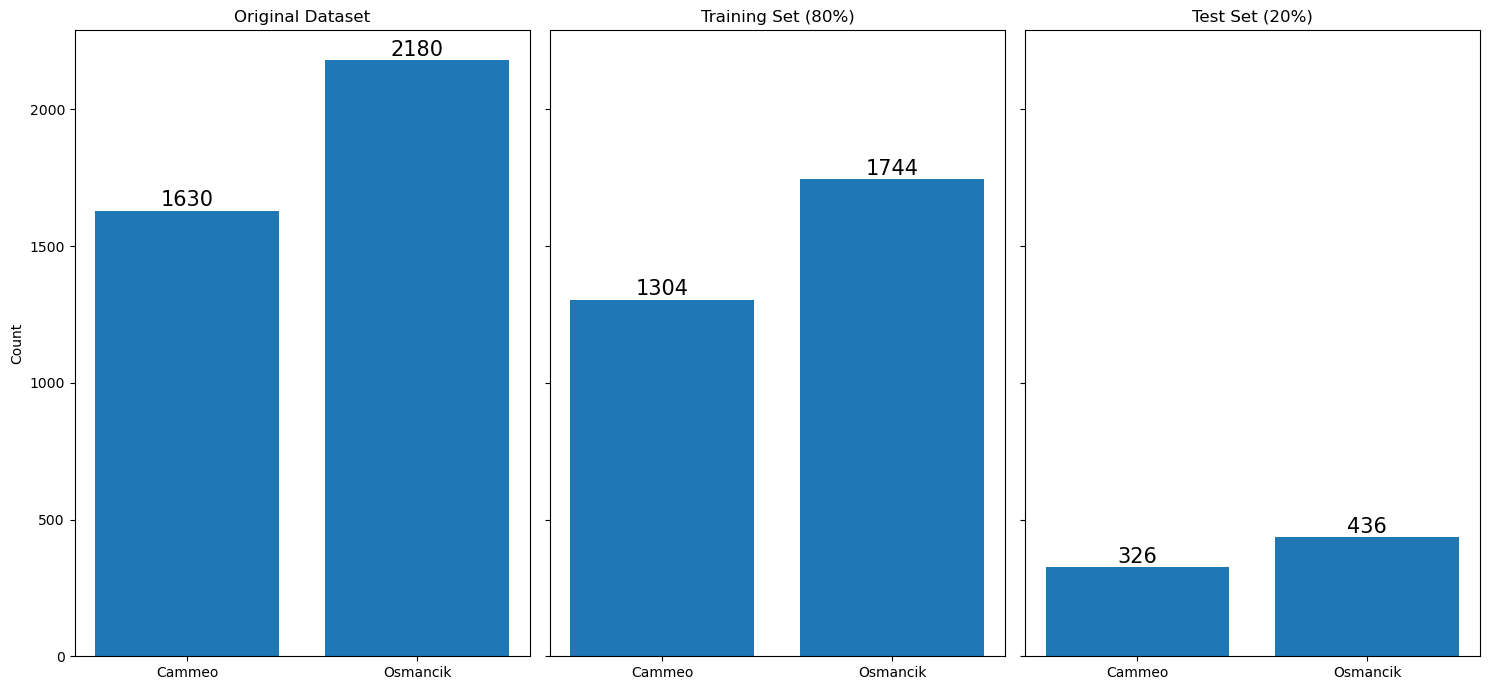

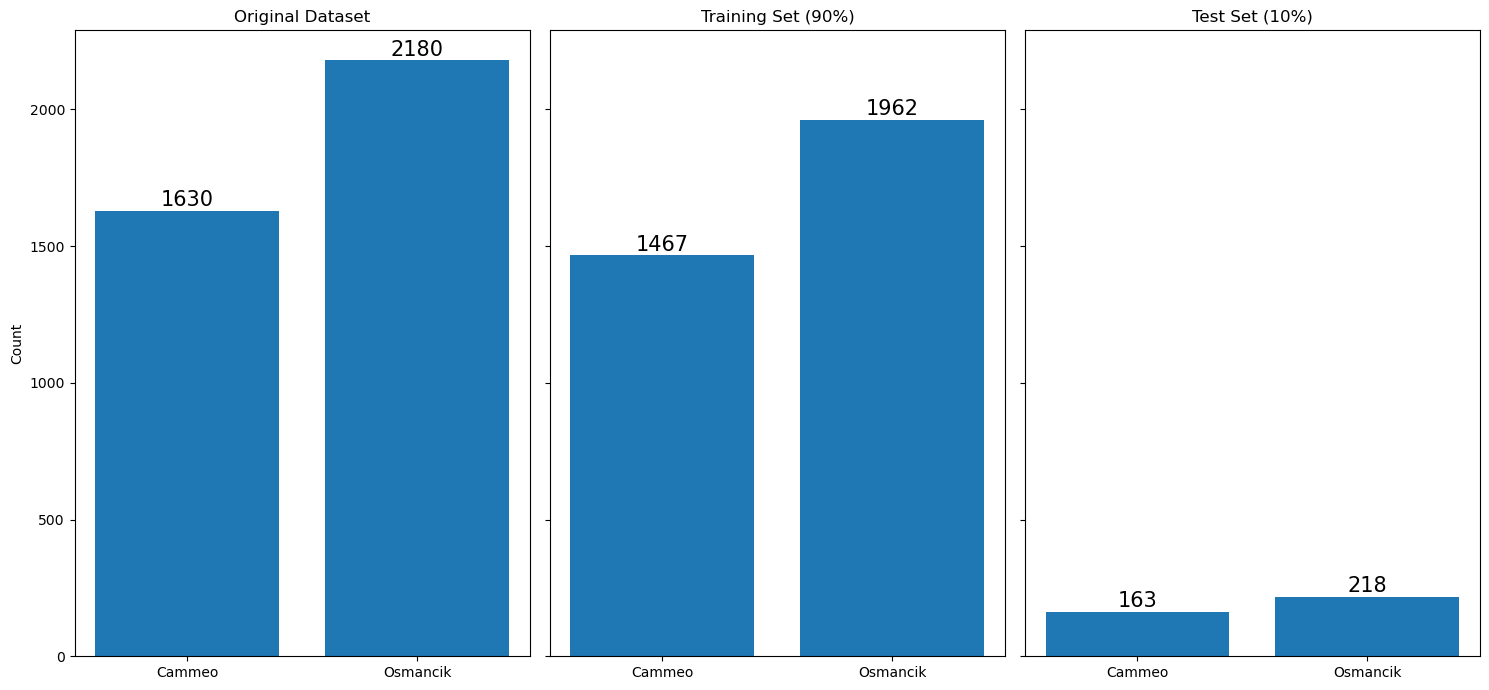

In [19]:
split_train_test = {}  # Dùng để lưu các tập sau khi chia
for train_size in proportions:
    feature_train, feature_test, label_train, label_test = stratified_split(features,label, train_size, random_state)
    visualize_train_test_distribution(label, label_train, label_test, train_size)
    split_train_test[train_size] = {
        'feature_train': feature_train,
        'label_train': label_train,
        'feature_test': feature_test,
        'label_test': label_test
    }

## **1.2 Xây dựng decision tree classifiers**


--- Train/Test Split: 40/60 ---


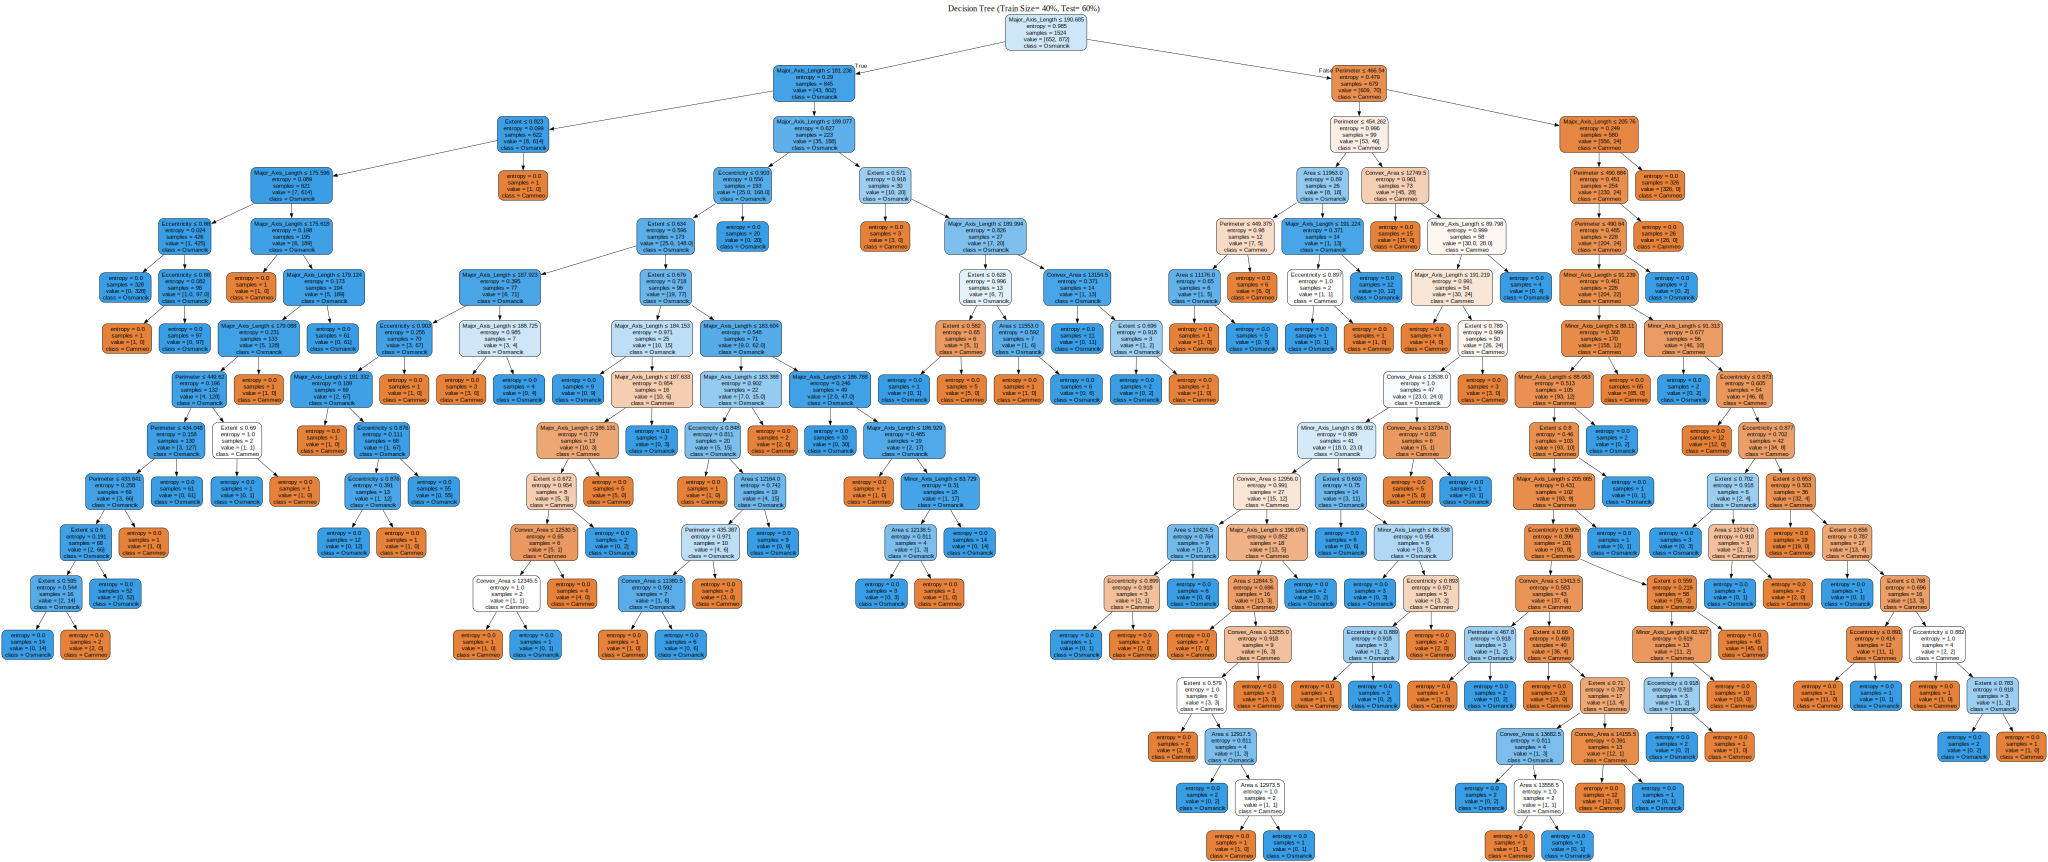


--- Train/Test Split: 60/40 ---


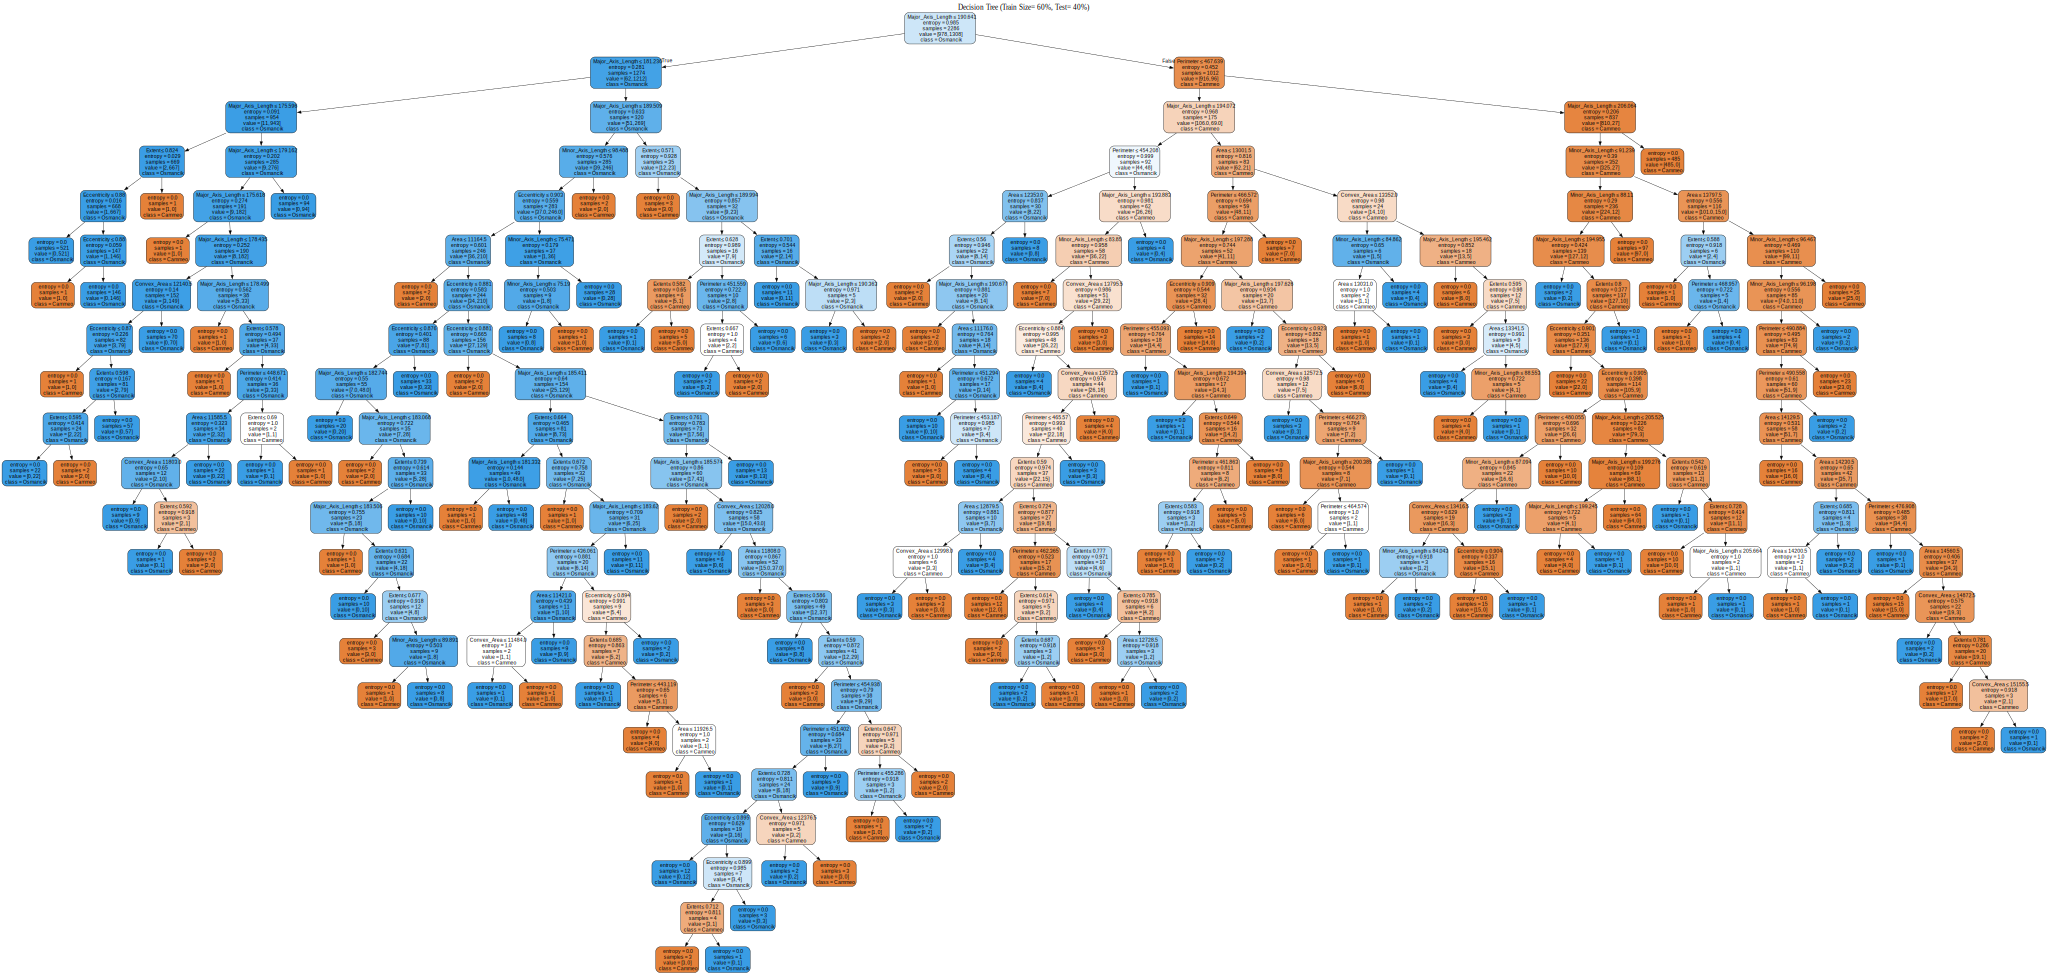


--- Train/Test Split: 80/20 ---


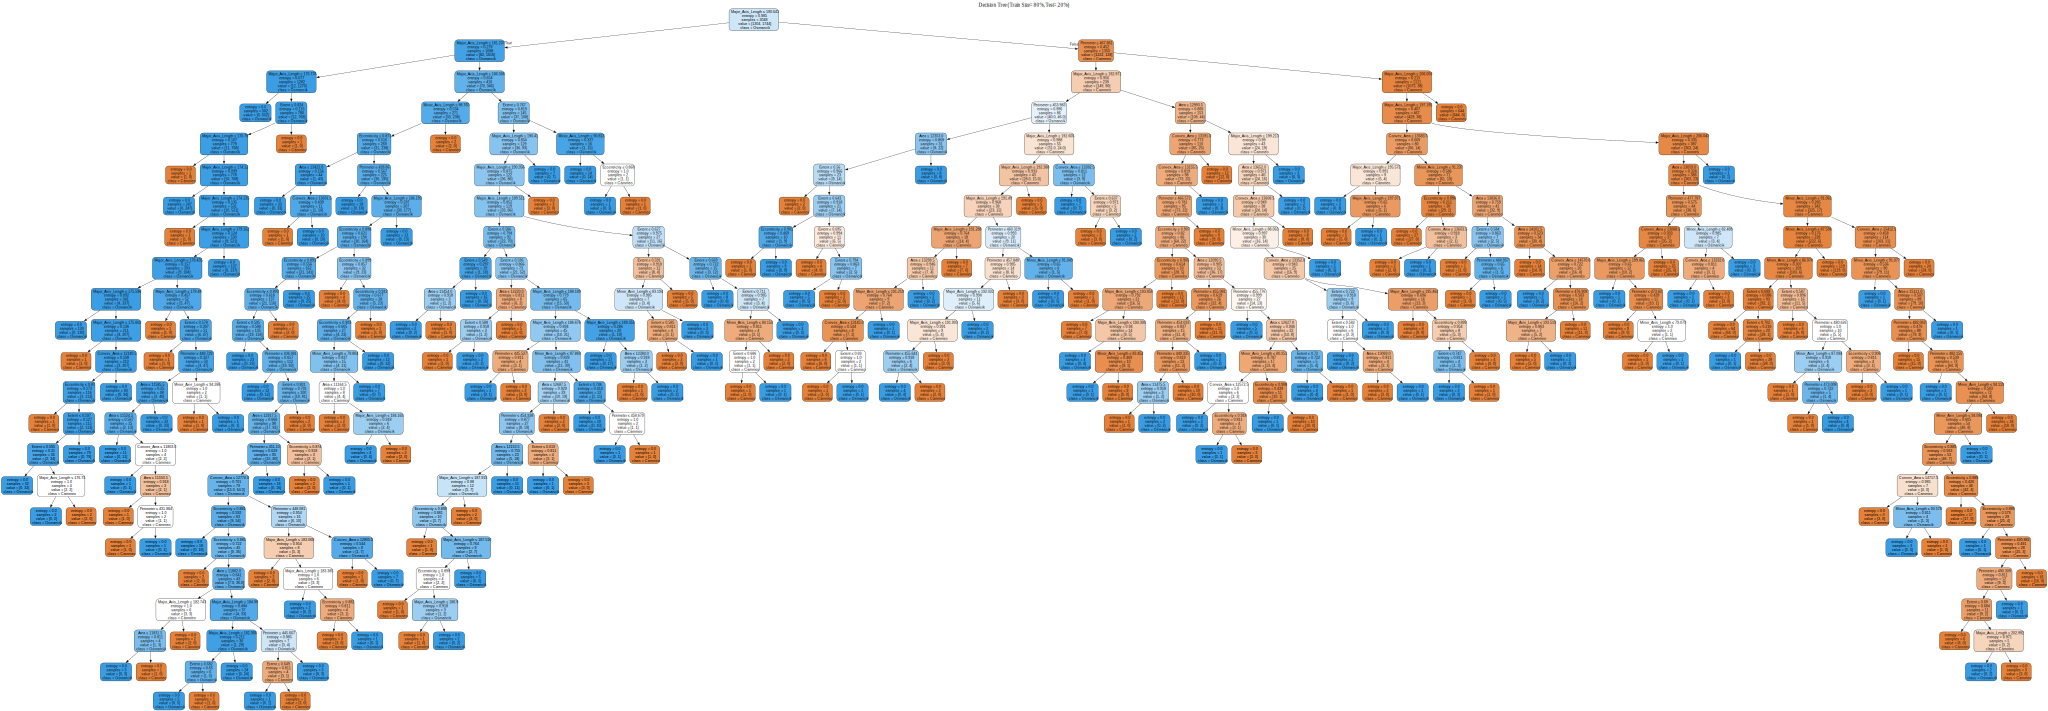


--- Train/Test Split: 90/10 ---


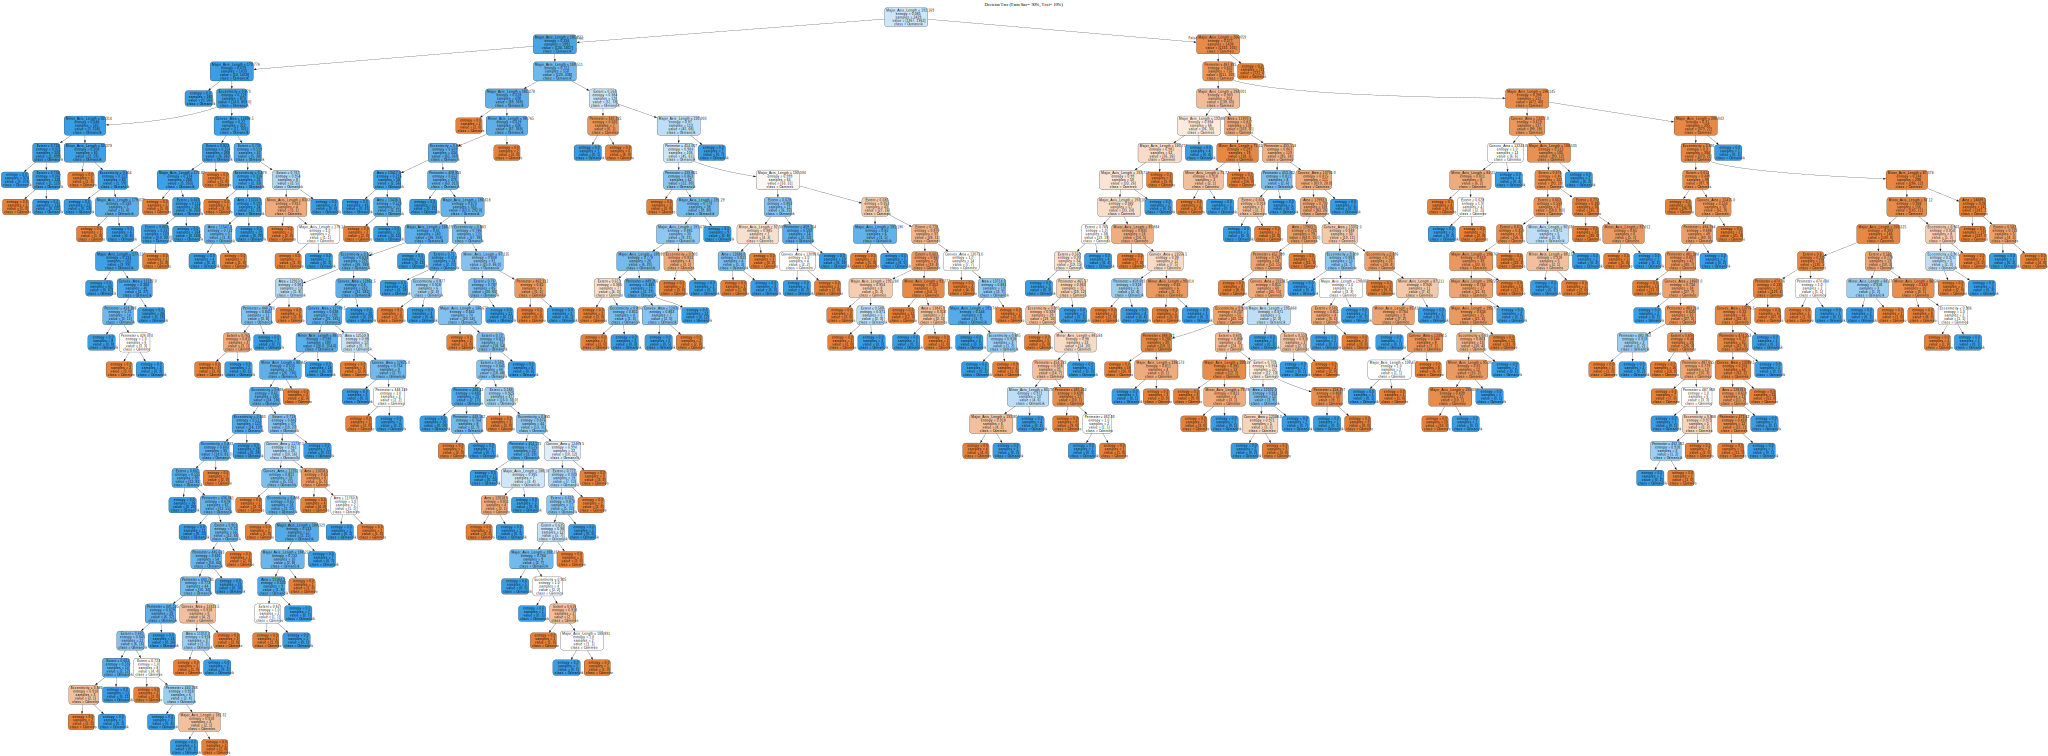

In [21]:
decision_trees = {}    # Dictionary này dùng để lưu các cây quyết định của từng loại tỷ lệ

for train_size in proportions:
    print(f"\n--- Train/Test Split: {int(train_size*100)}/{int(round(1-train_size, 2)*100)} ---")
    # Truy xuất các tập dữ liệu đã chia theo tỷ lệ
    X_train = split_train_test[train_size]['feature_train']
    X_test = split_train_test[train_size]['feature_test']
    y_train = split_train_test[train_size]['label_train']
    y_test = split_train_test[train_size]['label_test']
    
    # Khởi tạo một mô hình Decision Tree với tiêu chí 'entropy' (sử dụng độ đo thông tin Entropy)
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

    # Huấn luyện mô hình Decision Tree với dữ liệu huấn luyện X_train và nhãn y_train
    clf.fit(X_train, y_train)

    # Lưu cây quyết định để có thể tái sử dụng
    decision_trees[train_size] = clf

    # Xuất cây quyết định sang định dạng .dot, sử dụng các tham số như tên các đặc trưng và nhãn lớp
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=[str(cls) for cls in clf.classes_],
        filled=True,
        rounded=True,
        special_characters=True,
    )
    
    # Sửa đổi chuỗi dot để thêm tiêu đề
    modified_dot_data = dot_data.replace(
        'digraph Tree {', 
        f'digraph Tree {{\n\tlabel="Decision Tree (Train Size= {int(train_size*100)}%, Test= {int(round(1 - train_size, 2) * 100)}%)"\n\tfontsize=20\n\tlabelloc=t'
    )
    
    # Tạo Source với dữ liệu đã sửa đổi
    graph = graphviz.Source(modified_dot_data, format="svg")
    
    # Render ra SVG
    svg = graph.pipe(format='svg').decode('utf-8')
    display(SVG(svg))

    # Lưu ảnh
    os.makedirs('./output/decision_tree', exist_ok=True)
    pdf_filename = f"./output/decision_tree/decision_tree_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}"
    graph.render(filename=pdf_filename, format='pdf', cleanup=True, view=False)

    svg_filename = f"./output/decision_tree/decision_tree_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}"
    graph.render(filename=svg_filename, format='svg', cleanup=True, view=False)

### **1.3 Đánh giá bộ phân loại cây quyết định**

Classification Report (Train=40%, Test=60%)
              precision    recall  f1-score   support

      Cammeo       0.88      0.84      0.86       978
    Osmancik       0.89      0.91      0.90      1308

    accuracy                           0.88      2286
   macro avg       0.88      0.88      0.88      2286
weighted avg       0.88      0.88      0.88      2286

Confusion Matrix (Train=40%, Test=60%)


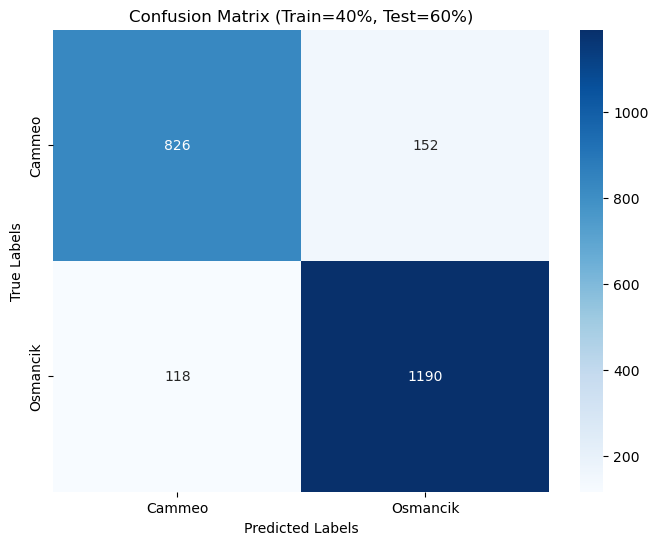

----------------------------------------------------------------------------------------------------
Classification Report (Train=60%, Test=40%)
              precision    recall  f1-score   support

      Cammeo       0.87      0.88      0.88       652
    Osmancik       0.91      0.90      0.91       872

    accuracy                           0.89      1524
   macro avg       0.89      0.89      0.89      1524
weighted avg       0.89      0.89      0.89      1524

Confusion Matrix (Train=60%, Test=40%)


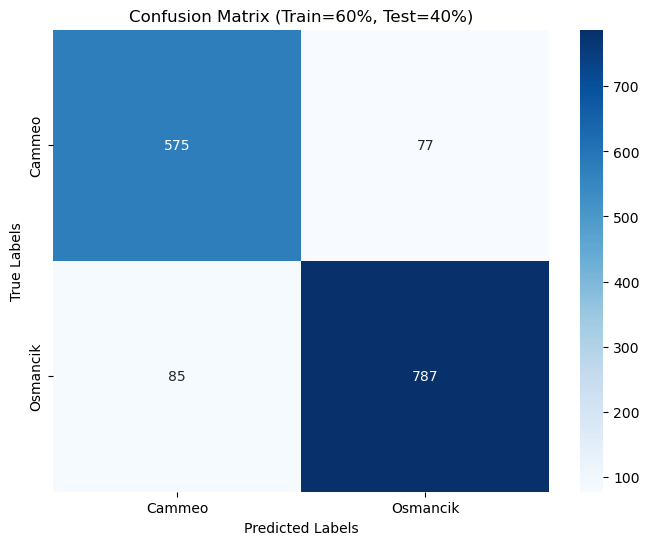

----------------------------------------------------------------------------------------------------
Classification Report (Train=80%, Test=20%)
              precision    recall  f1-score   support

      Cammeo       0.88      0.87      0.87       326
    Osmancik       0.90      0.91      0.91       436

    accuracy                           0.89       762
   macro avg       0.89      0.89      0.89       762
weighted avg       0.89      0.89      0.89       762

Confusion Matrix (Train=80%, Test=20%)


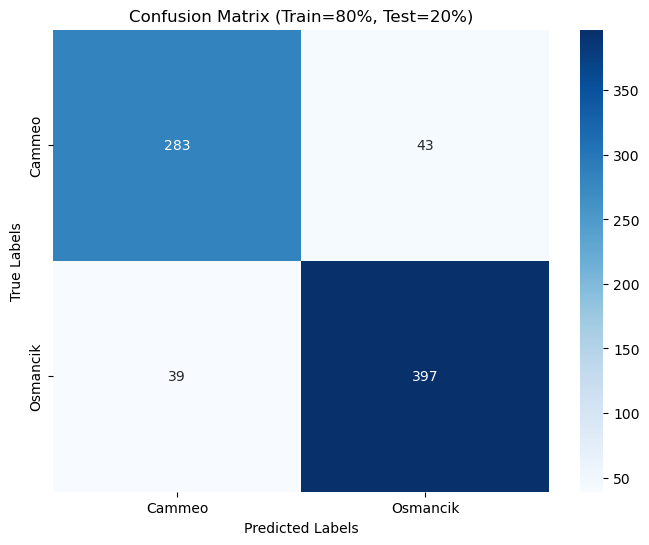

----------------------------------------------------------------------------------------------------
Classification Report (Train=90%, Test=10%)
              precision    recall  f1-score   support

      Cammeo       0.88      0.87      0.87       163
    Osmancik       0.90      0.91      0.91       218

    accuracy                           0.89       381
   macro avg       0.89      0.89      0.89       381
weighted avg       0.89      0.89      0.89       381

Confusion Matrix (Train=90%, Test=10%)


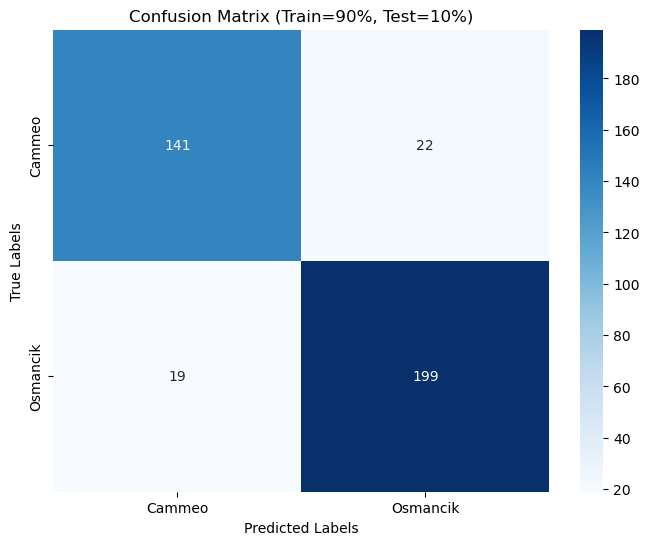

----------------------------------------------------------------------------------------------------


In [23]:
for train_size in proportions:
    # Truy xuất các tập dữ liệu đã chia theo tỷ lệ
    X_train = split_train_test[train_size]['feature_train']
    X_test = split_train_test[train_size]['feature_test']
    y_train = split_train_test[train_size]['label_train']
    y_test = split_train_test[train_size]['label_test']

    # Lấy ra các decision_trees đã lưu
    clf = decision_trees[train_size]
    
    # Dự đoán trên tập dữ liệu mẫu
    y_pred = clf.predict(X_test)
    
    # Tạo Classification Report
    print(f"Classification Report (Train={int(train_size * 100)}%, Test={int(round((1 - train_size), 2) * 100)}%)")
    print(classification_report(y_test, y_pred, target_names=[str(x) for x in clf.classes_]))
    
    # Tạo Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    print(f"Confusion Matrix (Train={int(train_size * 100)}%, Test={int(round((1 - train_size), 2) * 100)}%)")
    
    # Trực quan hóa Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title(f"Confusion Matrix (Train={int(train_size * 100)}%, Test={int(round((1 - train_size), 2) * 100)}%)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Lưu ảnh
    os.makedirs('./output/confusion_matrix', exist_ok=True)
    plt.savefig(f'./output/confusion_matrix/confusion_matrix_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f'./output/confusion_matrix/confusion_matrix_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}.svg', format='svg', bbox_inches='tight')
    plt.show()
    print('-' * 100)

### **1.4 Độ sâu và độ chính xác của cây quyết định**

----------------------------------------------------------------------------------------------------

Decision Tree with max_depth = None


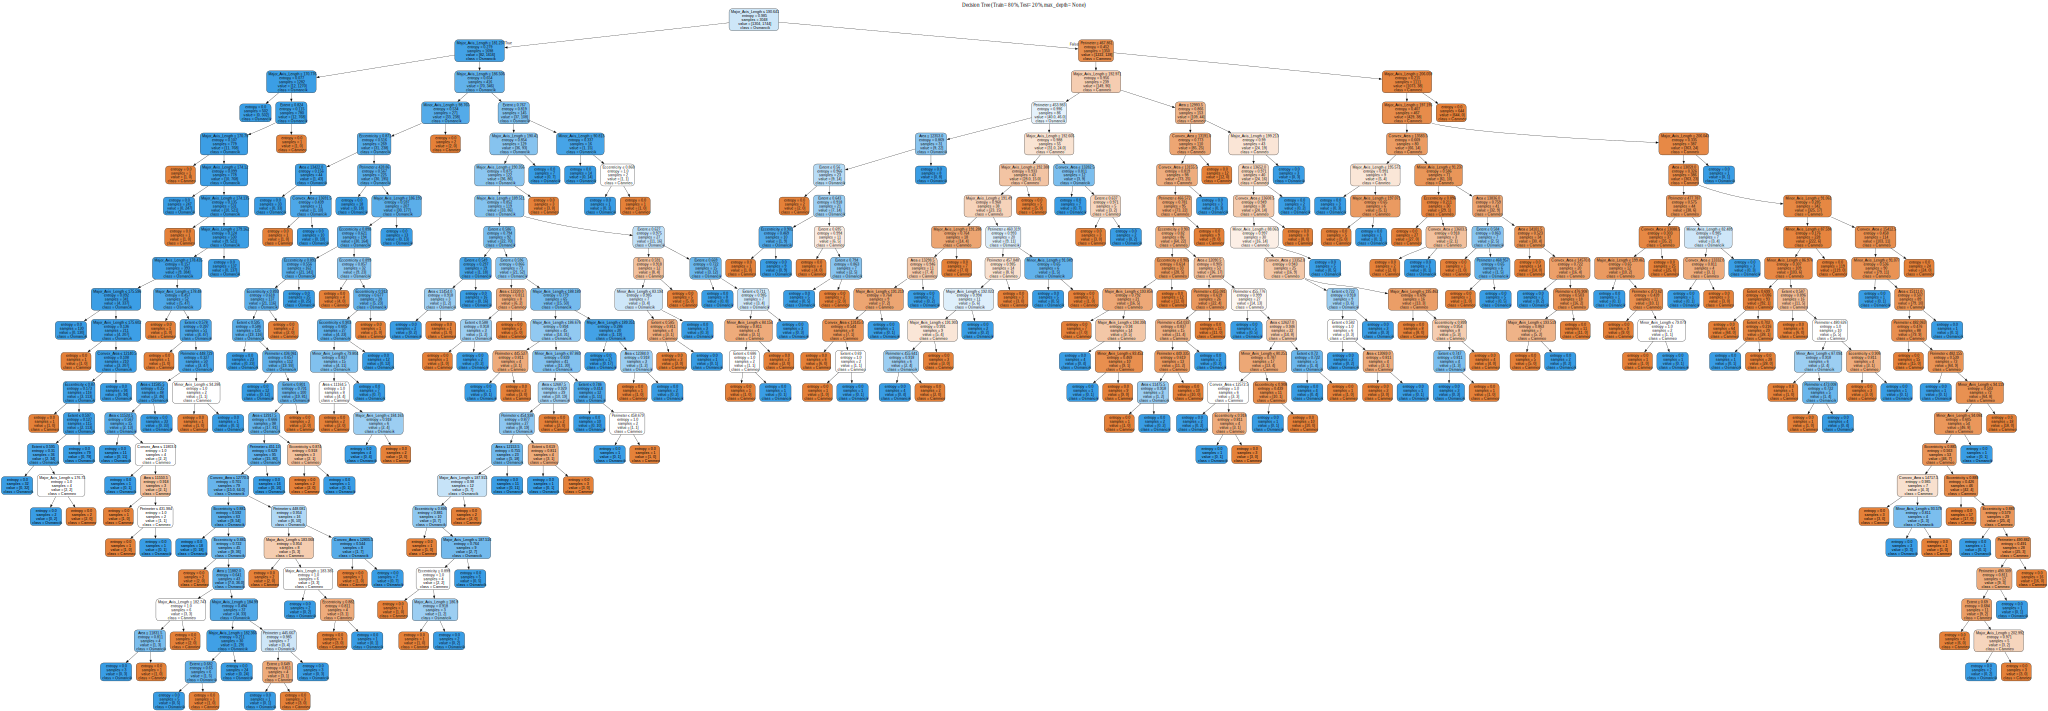

----------------------------------------------------------------------------------------------------

Decision Tree with max_depth = 2


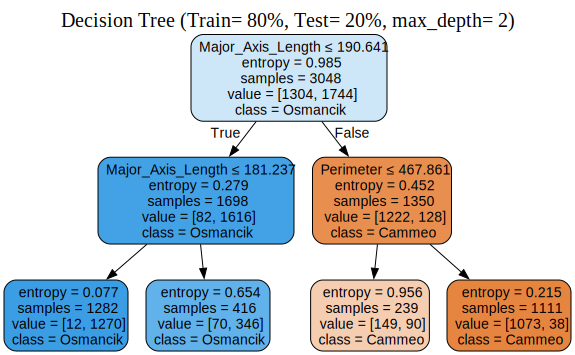

----------------------------------------------------------------------------------------------------

Decision Tree with max_depth = 3


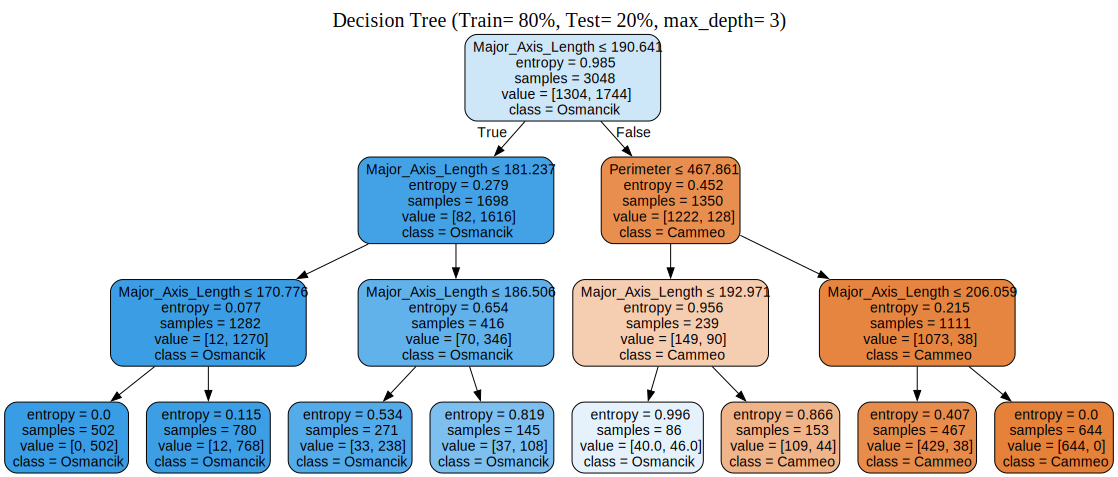

----------------------------------------------------------------------------------------------------

Decision Tree with max_depth = 4


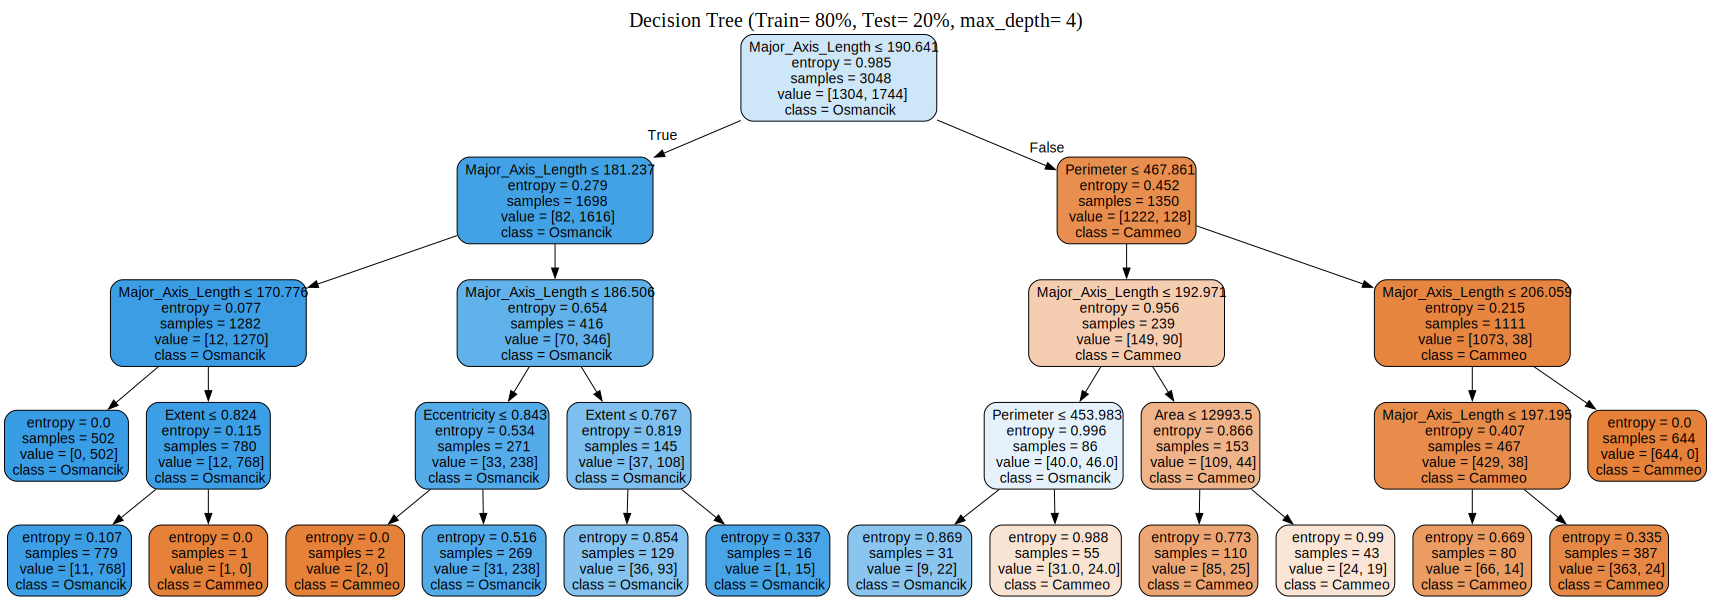

----------------------------------------------------------------------------------------------------

Decision Tree with max_depth = 5


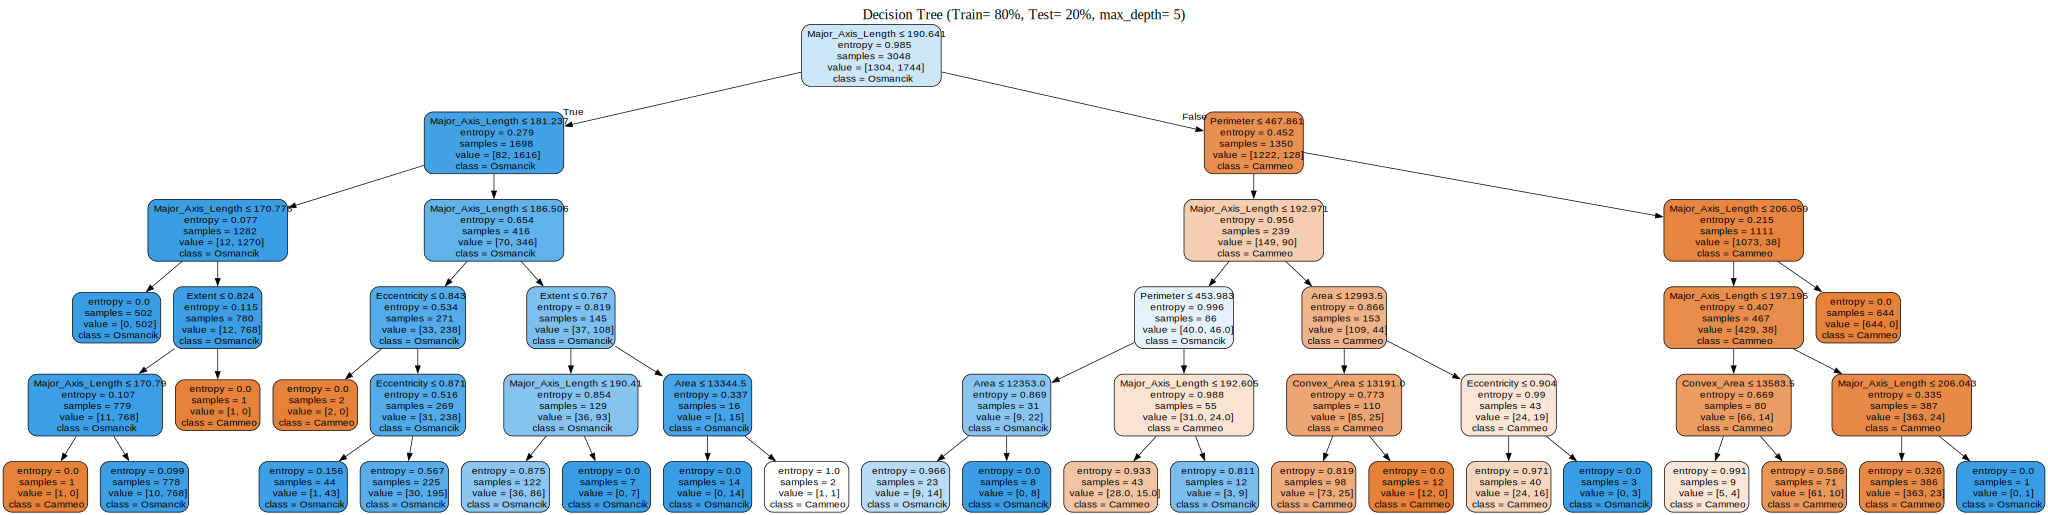

----------------------------------------------------------------------------------------------------

Decision Tree with max_depth = 6


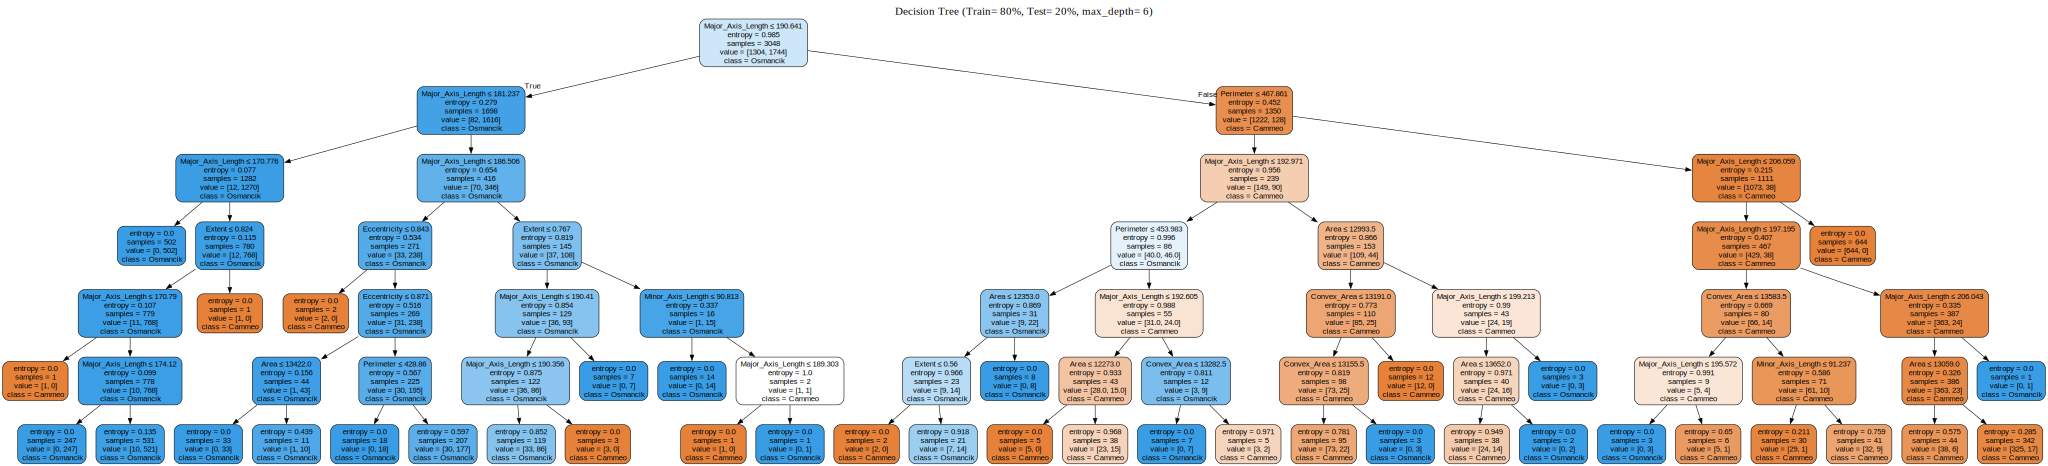

----------------------------------------------------------------------------------------------------

Decision Tree with max_depth = 7


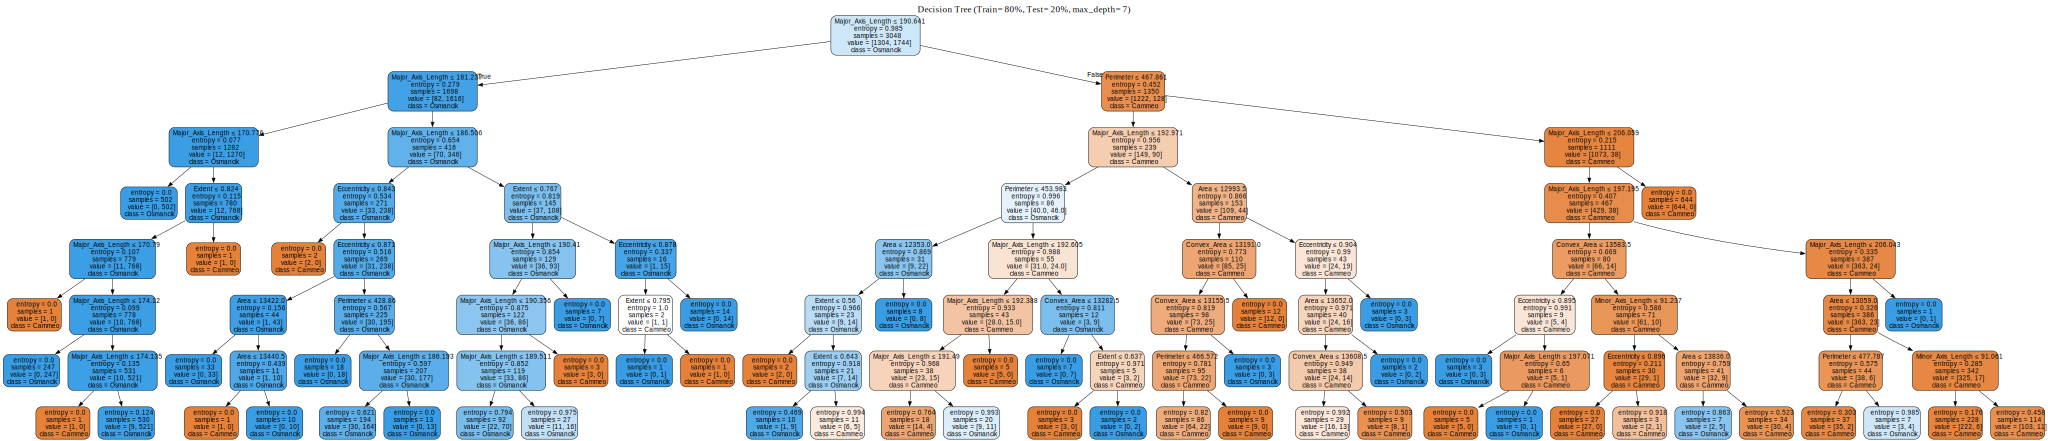

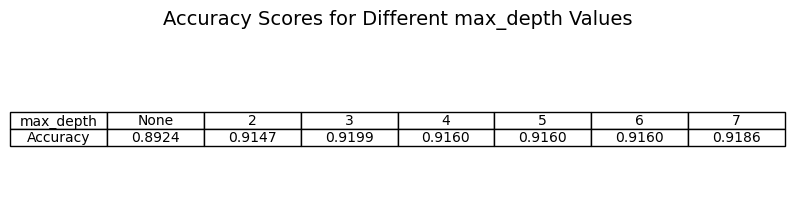

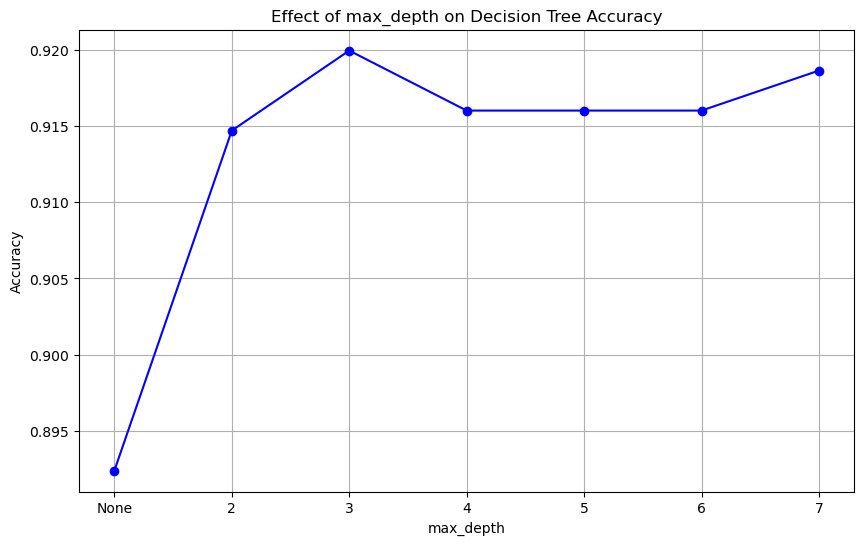

In [25]:
# Lấy dữ liệu từ tập 80% train
X_train = split_train_test[0.8]['feature_train']
X_test = split_train_test[0.8]['feature_test']
y_train = split_train_test[0.8]['label_train']
y_test = split_train_test[0.8]['label_test']

# Khởi tạo danh sách để lưu trữ độ chính xác của các mô hình
depths = [None, 2, 3, 4, 5, 6, 7]  # Danh sách các giá trị max_depth cho cây quyết định

accuracies = []  # Danh sách lưu trữ độ chính xác của mỗi mô hình

# Tạo biểu đồ cây quyết định dưới dạng SVG cho mỗi max_depth
for max_depth in depths:
    # Khởi tạo cây quyết định với max_depth cụ thể
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    
    # Huấn luyện mô hình với dữ liệu huấn luyện
    clf.fit(X_train, y_train)
    
    # Dự đoán trên tập kiểm tra
    y_pred = clf.predict(X_test)
    
    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # In ra thông báo về max_depth
    print("-" * 100)
    print(f"\nDecision Tree with max_depth = {max_depth}")
    
    # Xuất cây quyết định dưới dạng đồ họa SVG
    dot_data = export_graphviz(
        clf, 
        feature_names=feature_names,
        class_names=[str(cls) for cls in clf.classes_],
        filled=True, 
        rounded=True,  
        special_characters=True
    )
    
    # Sửa đổi chuỗi dot để thêm tiêu đề
    modified_dot_data = dot_data.replace(
        'digraph Tree {', 
        f'digraph Tree {{\n\tlabel="Decision Tree (Train= 80%, Test= 20%, max_depth= {max_depth})"\n\tfontsize=20\n\tlabelloc=t'
    )
    
    # Tạo Source với dữ liệu đã sửa đổi
    graph = graphviz.Source(modified_dot_data, format="svg")
    
    # Render ra SVG
    svg = graph.pipe(format='svg').decode('utf-8')
    display(SVG(svg))

    # Lưu ảnh
    os.makedirs('./output/decision_tree_depth', exist_ok=True)
    pdf_filename = f"./output/decision_tree_depth/decision_tree_max_depth_{max_depth}_80_20"
    graph.render(filename=pdf_filename, format='pdf', cleanup=True, view=False)

    pdf_filename = f"./output/decision_tree_depth/decision_tree_max_depth_{max_depth}_80_20"
    graph.render(filename=pdf_filename, format='svg', cleanup=True, view=False)

# Tạo bảng kết quả độ chính xác cho các giá trị max_depth
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
table_data = [["max_depth"] + [str(d) for d in depths], ["Accuracy"] + [f"{acc:.4f}" for acc in accuracies]]
table = ax.table(cellText=table_data, loc='center', cellLoc='center')
plt.title('Accuracy Scores for Different max_depth Values', fontsize=14, pad=20)
plt.savefig(f'./output/table.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./output/table.svg', format='svg', bbox_inches='tight')
plt.show()

# Vẽ đồ thị độ chính xác so với max_depth
plt.figure(figsize=(10, 6))
plt.plot([str(d) for d in depths], accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('max_depth')  # Nhãn trục x
plt.ylabel('Accuracy')  # Nhãn trục y
plt.title('Effect of max_depth on Decision Tree Accuracy')  # Tiêu đề đồ thị
plt.grid(True)  # Hiển thị lưới

# Lưu ảnh
plt.savefig(f'./output/line_chart_effect_of_max_depth.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./output/line_chart_effect_of_max_depth.svg', format='svg', bbox_inches='tight')

plt.show()  # Hiển thị đồ thị